# AAIC Self Case study - 2
----

## 'Dog Breed Identification' : Determine the breed of a dog in an image


#  


# Post training Error Analysis

In [7]:
#loading the libraries
import tensorflow as tf 
import pandas as pd 
import numpy as np 
import cv2 
import os 
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.preprocessing import image
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

from keras.models import Sequential
from keras.layers import Dense,MaxPooling2D,Dropout,Conv2D,GlobalAveragePooling2D,Flatten

<b> Loading the datasets

In [2]:
train = pd.read_csv('labels.csv')

#getting the path to the images
train['path'] = "train/" + train['id'] + '.jpg'
train.head()

id             breed  \
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull   
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo   
2  001cdf01b096e06d78e9e5112d419397          pekinese   
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick   
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever   

                                         path  
0  train/000bec180eb18c7604dcecc8fe0dba07.jpg  
1  train/001513dfcb2ffafc82cccf4d8bbaba97.jpg  
2  train/001cdf01b096e06d78e9e5112d419397.jpg  
3  train/00214f311d5d2247d5dfe4fe24b2303d.jpg  
4  train/0021f9ceb3235effd7fcde7f7538ed62.jpg

<b> Label Encoding 

In [5]:
train['label']=train.breed

le=LabelEncoder()

train.label=le.fit_transform(train.label)
train.head()

id             breed  \
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull   
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo   
2  001cdf01b096e06d78e9e5112d419397          pekinese   
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick   
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever   

                                         path  label  
0  train/000bec180eb18c7604dcecc8fe0dba07.jpg     19  
1  train/001513dfcb2ffafc82cccf4d8bbaba97.jpg     37  
2  train/001cdf01b096e06d78e9e5112d419397.jpg     85  
3  train/00214f311d5d2247d5dfe4fe24b2303d.jpg     15  
4  train/0021f9ceb3235effd7fcde7f7538ed62.jpg     49

<b> Train-test split

In [8]:
train, val = train_test_split(train, test_size=0.10, random_state=42)

<b> Loading the InceptionResnetV2 pretrained model

In [9]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

#loading the pre-trained model
transfer_model = InceptionResNetV2(include_top = False,
                                   weights ='imagenet',
                                  input_shape = (224,224,3))

#making all the layers non-trainable so that it takes the weights of the pre trained model on imagenet dataset
transfer_model.trainable = False 

<b> Adding our own layers

In [10]:
model = Sequential()
model.add(transfer_model)
model.add(GlobalAveragePooling2D())

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))



model.add(Dense(120,activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 9, 9, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               30840     
                                                                 
Total params: 54,761,048
Trainable params: 424,312
Non-t

<b> Loading the best model

In [12]:
model.load_weights("case_study_2_inres_model_19.h5")

<b> Dataset shapes

In [65]:
print("Train data shape:",train.shape)
print("Validation data shape:",val.shape)

Train data shape: (9199, 4)
Validation data shape: (1023, 4)


For our error analysis, we will be using the validation images only because we didn't use the validation images for training and also for the competition's test dataset, we don't have the ground truths. Here we see that since we have done the train-test split as 90-10, we only have around 1k points in our validation set with which we will be proceeding with our error analysis.

# Error Analysis

<b> We will be dividing our validation images into 3 parts: worst, medium and best.
    
 <b>   1. worst- This will contain images where the actual class label's probability predicted by the model is less than 0.4.<br>
 <b>   2. medium- This will contain images where the actual class label's probability predicted by the model lies in the range of [0.4,0.8).<br>
 <b>  3. best- This will contain images where the actual class label's probability predicted by the model is more or equal to 0.8.
   

In [22]:
worst=[]
medium=[]
best=[]

for i,j,k in tqdm(zip(val.breed.values,val.path.values,val.label.values)):
    
    #getting the image and resizing it
    img=image.load_img(path=j,target_size=(224,224,3))
    img=image.img_to_array(img)
    test_img=img.reshape((1,224,224,3))
    
    #prediction using the trained model
    prediction = model.predict(test_img/255)
    
    #getting the probability for the actual class label
    actual_prob=round(prediction[0][k],3)
    
    
    #diving the images into suitable buckets based on probability
    if actual_prob < 0.4:
        worst.append([j,i,le.inverse_transform([np.argmax(prediction)])[0],actual_prob])
        
    
    elif actual_prob >= 0.8:
        best.append([j,i,le.inverse_transform([np.argmax(prediction)])[0],actual_prob])
        
    else:
        medium.append([j,i,le.inverse_transform([np.argmax(prediction)])[0],actual_prob])
        

0it [00:00, ?it/s]

<b> Getting the percentages

In [27]:
print("Count of worst:", len(worst),"(",round(len(worst)/1023*100,3),"%)")
print("Count of medium:", len(medium),"(",round(len(medium)/1023*100,3),"%)")
print("Count of best:", len(best),"(",round(len(best)/1023*100,3),"%)")

Count of worst: 83 ( 8.113 %)
Count of medium: 57 ( 5.572 %)
Count of best: 883 ( 86.315 %)


<b> Comments - 
* We see that majority of the points, ie, around 86% of the images are correctly classified, which is a very good thing and froom this we can conclude that our model is performing good.
* We notice that around 6% of the points are in the medium category. We need to go and check where the model learning went wrong and why the probability scores are coming less.
* We see that around 8% of the points lie in the worst category. Our model is performing terrible for these points. It may happen that our model is getting confused between the actual breed and the predicted breed.

<b> Getting the counts where actual is equal to the predicted breed

In [32]:
c=0
for i in worst:
    if i[1]==i[2]:
        c+=1
        
print("Count of images in worst category where actual is equal to predicted:",c,"(",round(c/len(worst)*100,3),"%)")

c=0
for i in medium:
    if i[1]==i[2]:
        c+=1
        
print("Count of images in medium category where actual is equal to predicted:",c,"(",round(c/len(medium)*100,3),"%)")



c=0
for i in best:
    if i[1]==i[2]:
        c+=1
        
print("Count of images in best category where actual is equal to predicted:",c,"(",round(c/len(best)*100,3),"%)")

Count of images in worst category where actual is equal to predicted: 1 ( 1.205 %)
Count of images in medium category where actual is equal to predicted: 49 ( 85.965 %)
Count of images in best category where actual is equal to predicted: 883 ( 100.0 %)


<b>Comments-

* We see that in the worst category, only 1 image is predicted correctly, rest all are incorrectly classified. This might happen because the probabilities for the actual class label is too low and for the predicted class label, the probability is high.
* We see that for the medium category, 86% of the images are accurately predicted, which is a good thing to notice. Here it might happen that our model is getting confused between some other breed, thus the probability values for actual breed might be less.
* This is very much eye catching that of all the points that are in the best category, all the predicted correctly.

<b> The only image in the worst category which is predicted correctly:

['train/82052dbdc6378944f3269b8b5507f11d.jpg', 'cocker_spaniel', 'cocker_spaniel', 0.325]


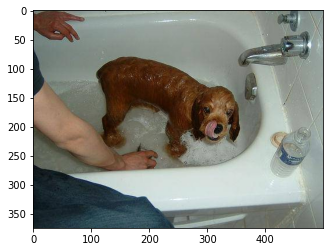

In [34]:
for i in worst:
    if i[1]==i[2]:
        print(i)
        
img = Image.open('train/82052dbdc6378944f3269b8b5507f11d.jpg')
plt.imshow(img)
plt.show()

Comment- We can say that the model got confused between other breeds and assigned a very less probability value to the correct breed because the portion of the image where the dog is occupying the image is very less. It might happen that because of the background features which can be same for other breed images, the model gt confused.  

<b> Analysis for worst category

In [37]:
#getting the random indices for worst category
indices=np.random.choice(range(83),10,replace=False)
indices

array([19, 66, 68, 40, 37, 63, 65,  6, 62, 33])

In [38]:
for i in indices:
    print(worst[i])

['train/c925c6050b9846ea6c7f8a9e1314c07c.jpg', 'collie', 'great_pyrenees', 0.001]
['train/4e4173a3a2e7d49f43ddfe3f167ea397.jpg', 'pekinese', 'shih-tzu', 0.138]
['train/f7850cfce0e0d79627dfb63d71d97b72.jpg', 'siberian_husky', 'eskimo_dog', 0.318]
['train/351a08cd2b2fca3a3f57cf4007857231.jpg', 'schipperke', 'collie', 0.002]
['train/61ee3e61d002e571a3066ab8aacfad0c.jpg', 'toy_terrier', 'yorkshire_terrier', 0.0]
['train/566c80fd7885e3944139e9ceb0df54d0.jpg', 'miniature_poodle', 'standard_poodle', 0.136]
['train/4357eac7a349ea29997ddaf2128f08d1.jpg', 'standard_schnauzer', 'wire-haired_fox_terrier', 0.086]
['train/1d7b95ca93d943e74adb6f6777d3ac6e.jpg', 'bull_mastiff', 'american_staffordshire_terrier', 0.0]
['train/cfd115aa91d1b341574869fd5b9a1afd.jpg', 'appenzeller', 'rottweiler', 0.003]
['train/53473e80b84c98e1f6e29f1227001a07.jpg', 'collie', 'shetland_sheepdog', 0.074]


<b> Some images in the worst category with the actual image in the left and one image to show how the predicted breed looks in actual

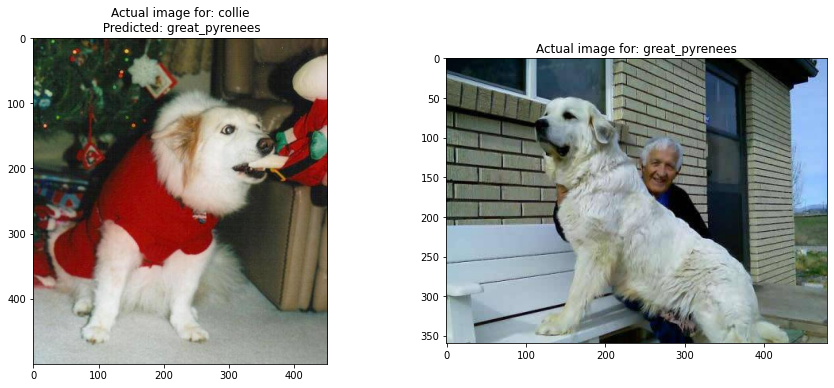



----------------------------------------------------------------------------------------------------




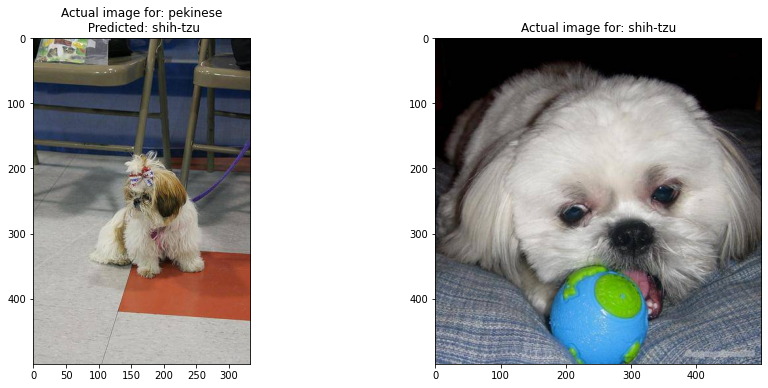



----------------------------------------------------------------------------------------------------




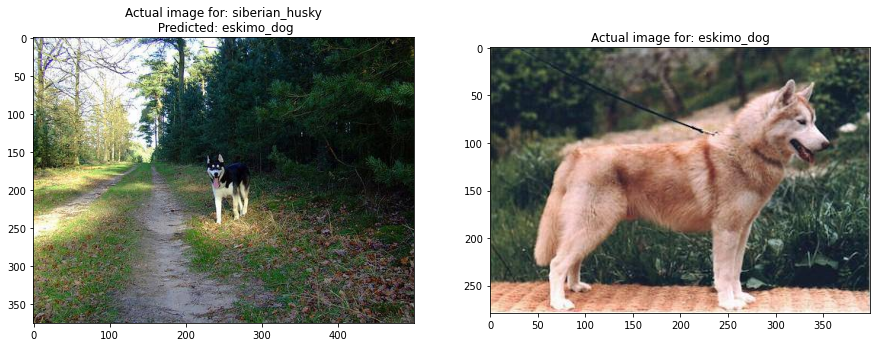



----------------------------------------------------------------------------------------------------




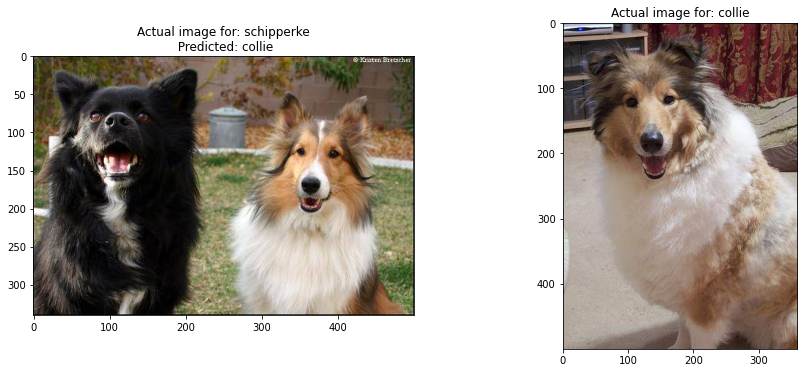



----------------------------------------------------------------------------------------------------




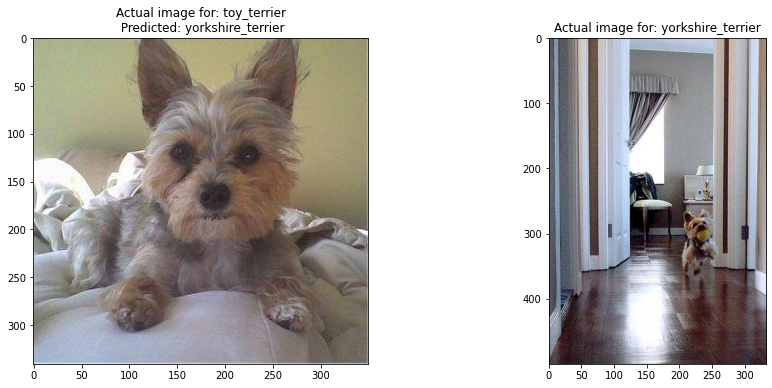



----------------------------------------------------------------------------------------------------




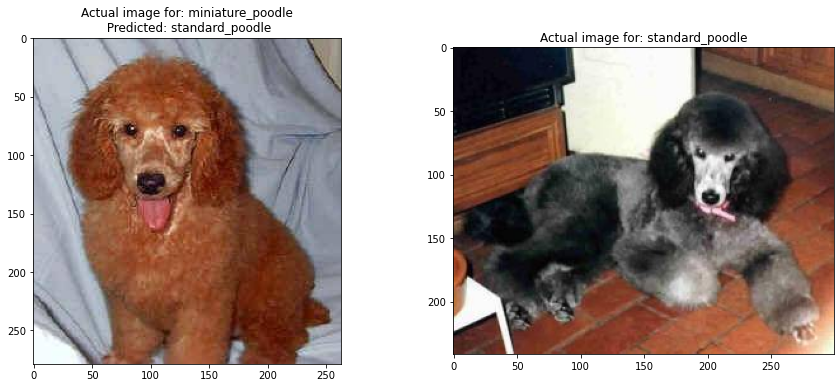



----------------------------------------------------------------------------------------------------




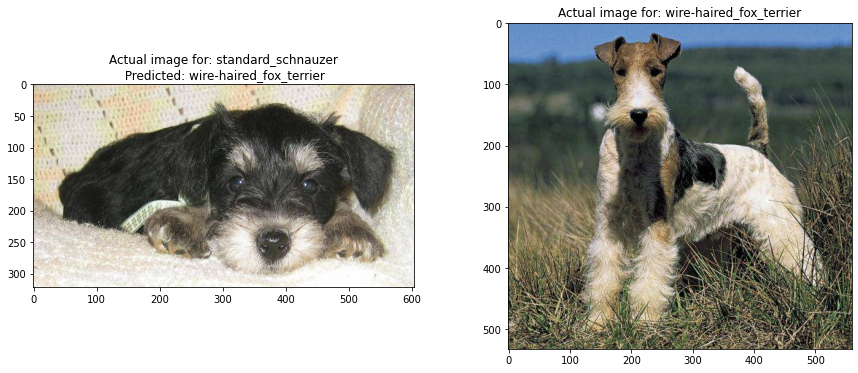



----------------------------------------------------------------------------------------------------




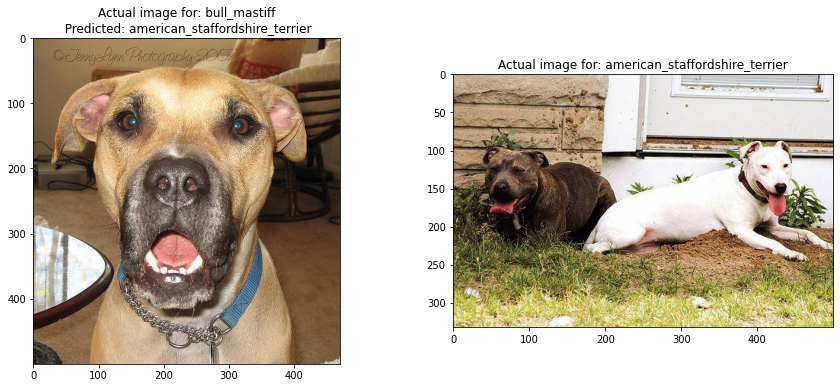



----------------------------------------------------------------------------------------------------




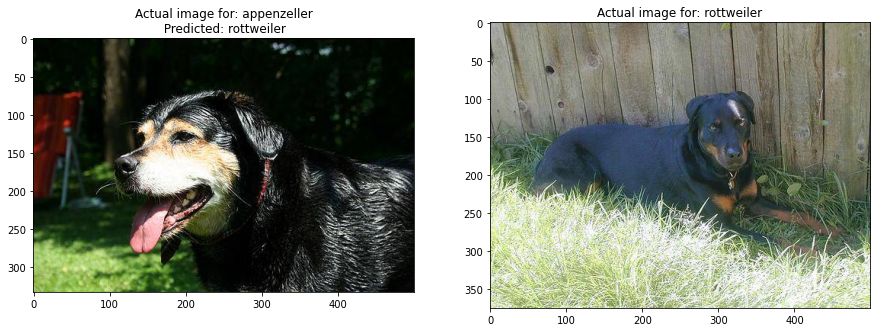



----------------------------------------------------------------------------------------------------




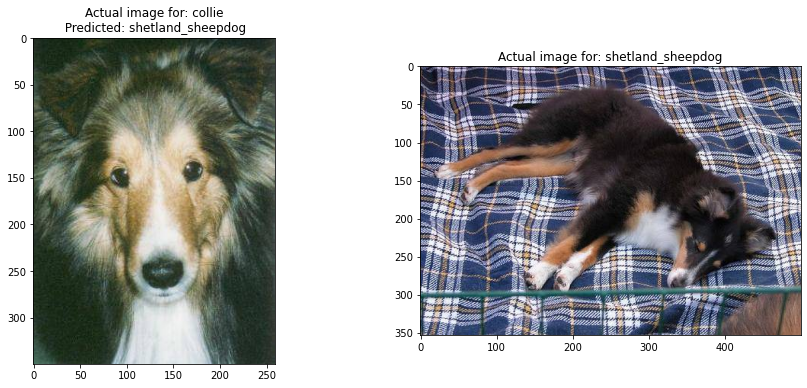



----------------------------------------------------------------------------------------------------




In [61]:
for i in indices:
    actual_breed=train[train.breed==worst[i][2]].values

    plt.figure(figsize=(15,6))
    plt.subplot(121)
    img = Image.open(worst[i][0])
    plt.title("Actual image for: "+worst[i][1]+"\n Predicted: "+worst[i][2])
    plt.imshow(img)

    plt.subplot(122)
    img = Image.open(actual_breed[0][2])
    plt.title("Actual image for: "+worst[i][2])
    plt.imshow(img)
    plt.show()
    
    print("\n")
    print("--"*50)
    print("\n")

Comments-
    
Why the model got confused between the predicted and the actual breed:
1. Both are white in color, and almost very similar in looks. We humans might confuse them which dog is of which breed.
2. Both are very similar in their looks.
3. Here the body color of the dogs are very different, but the dogs faces are very similar in looks, model got confused. Also there are green patches in both. This can be a reason too.
4. Here in the test image, 2 dogs are present. The dog in the right looks very similar to the predicted one. Here the actual image is labelled for the dog at left but since 2 of them are present, our model predicted the right one and got wrong in evaluating.
5. Both of the are variations or sub-breeds of a major breed and looks very identical. So model got confused.
6. Both of the are variations or sub-breeds of a major breed, though there is a body color difference. So model got confused.
7. Both the dogs are very different from one another, but the model might get confused looking at the nose area because they looked very identical.
8. Both the dogs are very different from one another, but the model might get confused looking at the nose area because they looked very identical. Also, the mouths are open for all the dogs. So this can be reason too that the model has learnt wrongly.
9. Both the dogs are very different from one another. body color can be a reason.
10. Both athe dogs are very similar in their looks. The model got confused.

<b> Medium category where the actual breed is not equal to predicted breed

In [62]:
indices=[]
c=0
for i in medium:
    if i[1]!=i[2]:
        indices.append(c)
    c+=1
    
for i in indices:
    print(medium[i])

['train/16052ac2a6ff7f1fbbc85885d2a7c467.jpg', 'lhasa', 'shih-tzu', 0.409]
['train/f33c92eca07a03a242b4a9986fc66d9b.jpg', 'standard_poodle', 'affenpinscher', 0.422]
['train/987de7672a009521f6d8c7cb6f679255.jpg', 'standard_schnauzer', 'miniature_schnauzer', 0.49]
['train/ad65b6e2e9ab5a215f931155b4ca27f8.jpg', 'walker_hound', 'english_foxhound', 0.41]
['train/2be5c6c4b3bcadec0a579197586ef114.jpg', 'welsh_springer_spaniel', 'clumber', 0.453]
['train/5e10c59dd98139adcdb59986ab9e5b19.jpg', 'toy_poodle', 'miniature_poodle', 0.443]
['train/136e0fc1f67b72037c0e60faff6061f2.jpg', 'scottish_deerhound', 'irish_wolfhound', 0.451]
['train/4505c9f9ead58992ff0ded371e401ca7.jpg', 'miniature_pinscher', 'rottweiler', 0.455]


<b> Medium category where the actual breed is equal to predicted breed

In [66]:
indices=[]
c=0
for i in medium:
    if i[1]==i[2]:
        indices.append(c)
    c+=1
    
for i in indices:
    print(medium[i])

['train/29b06acb65e3873dfab2a7b2581d6a35.jpg', 'toy_poodle', 'toy_poodle', 0.719]
['train/b0b7aaaa673295ace0ae4d9f248b71f1.jpg', 'siberian_husky', 'siberian_husky', 0.593]
['train/64d840b8b3948c5ffd8644b1539f5c00.jpg', 'silky_terrier', 'silky_terrier', 0.601]
['train/ac5bb7ba4513320fb91f52a8190a55b4.jpg', 'australian_terrier', 'australian_terrier', 0.633]
['train/c8ce22f51941dc011dc544ee53076600.jpg', 'tibetan_mastiff', 'tibetan_mastiff', 0.65]
['train/38ef9e4d9065f4d8a7efd44d0f83ef08.jpg', 'standard_poodle', 'standard_poodle', 0.776]
['train/ab5c5ee4b0431f391fde0ba59a253907.jpg', 'toy_poodle', 'toy_poodle', 0.796]
['train/bc8404a3b9d96fb5626360e0011e20b8.jpg', 'border_collie', 'border_collie', 0.692]
['train/0a7899ed6a15f4af8f28e01c9c44dcfe.jpg', 'miniature_poodle', 'miniature_poodle', 0.532]
['train/a3d4baf88f32073eb9fda83ff629728e.jpg', 'brittany_spaniel', 'brittany_spaniel', 0.776]
['train/78cb1dbdd48e40691132cba7a39282bd.jpg', 'standard_schnauzer', 'standard_schnauzer', 0.722]
['t

Comments-

* We notice one thing that for medium category, where the probability scores for actual breed are less than 5, only there had been misclassifications, else for the other half where the actual breed probability scores are greater than or equal to 5, those breeds are correctly classified.

* As earlier mentioned due to some same background features in other images, or similar looks of the dogs, the model miht get confused that assigns less probabilities for the actual breed.

<b> The images in the medium category with the actual image in the left and one image to show how the predicted breed looks in actual

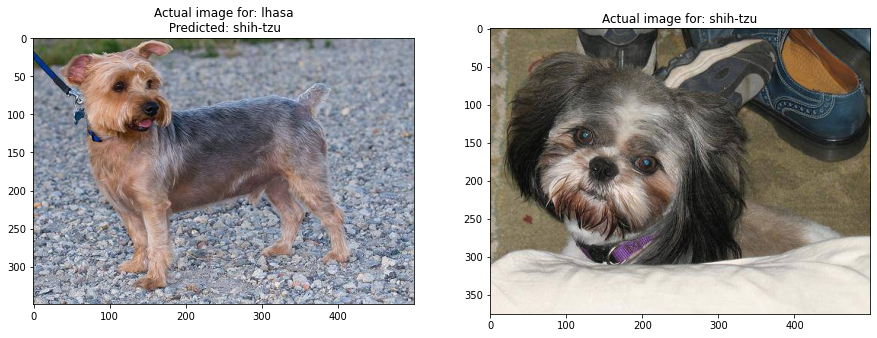



----------------------------------------------------------------------------------------------------




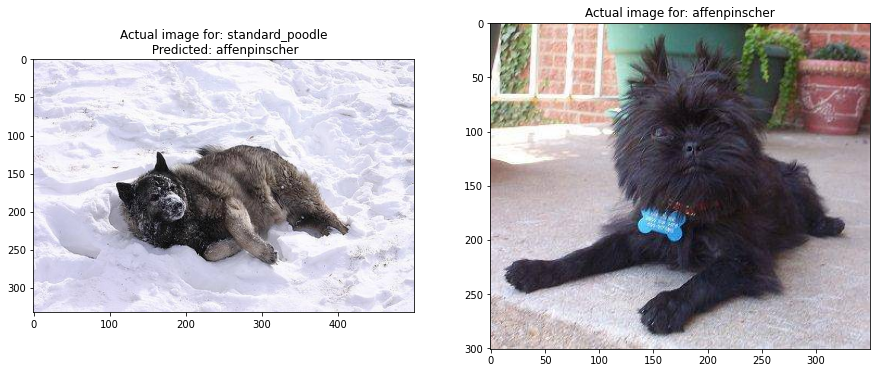



----------------------------------------------------------------------------------------------------




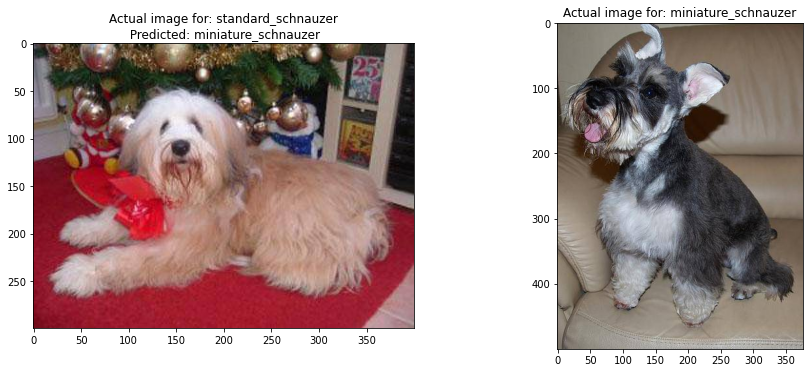



----------------------------------------------------------------------------------------------------




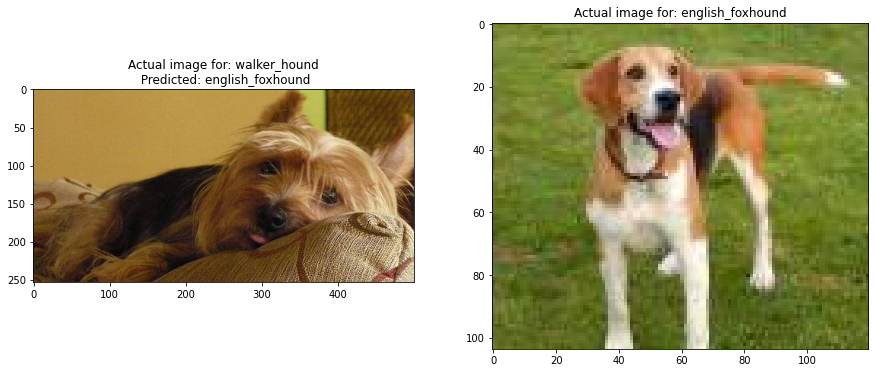



----------------------------------------------------------------------------------------------------




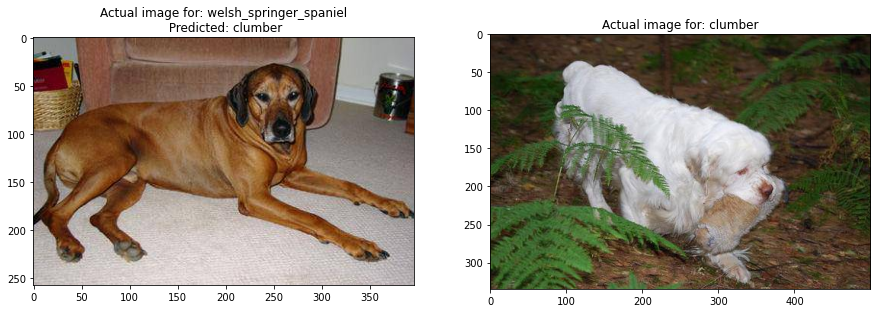



----------------------------------------------------------------------------------------------------




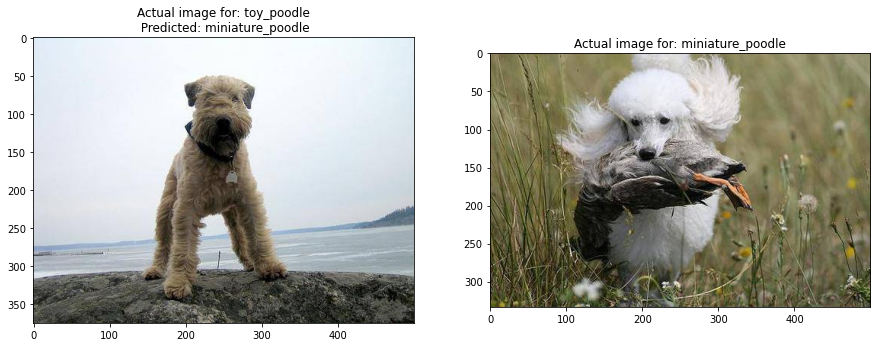



----------------------------------------------------------------------------------------------------




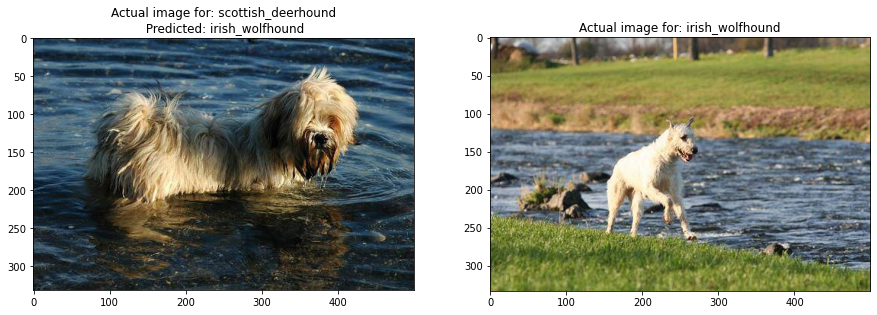



----------------------------------------------------------------------------------------------------




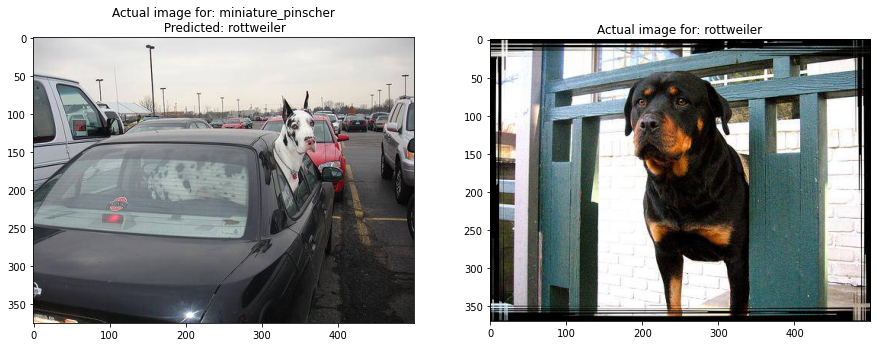



----------------------------------------------------------------------------------------------------




In [64]:
for i in indices:

    actual_breed=train[train.breed==medium[i][2]].values

    plt.figure(figsize=(15,6))
    plt.subplot(121)
    img = Image.open(worst[i][0])
    plt.title("Actual image for: "+medium[i][1]+"\n Predicted: "+medium[i][2])
    plt.imshow(img)

    plt.subplot(122)
    img = Image.open(actual_breed[5][2])
    plt.title("Actual image for: "+medium[i][2])
    plt.imshow(img)
    plt.show()
    
    print("\n")
    print("--"*50)
    print("\n")

Comments-
    
Why the model got confused between the predicted and the actual breed:
1. Both the dogs are very much identical, specially for the face area.
2. Since both the dogs are black in color, though they are very different in their formation, still model got confused due to body color.
3. Both of the are variations or sub-breeds of a major breed, though there is a body color difference and structure difference. So model got confused.
4. Both of the are variations or sub-breeds of a major breed and both the dogs are black and brown mixed in color. So model got confused.
5. Both the dogs are very different from one another, but the model might get confused looking at the nose area because they looked very identical. Also, the mouths are open for all the dogs. So this can be reason too that the model has learnt wrongly.
6. Both of the are variations or sub-breeds of a major breed, though there is a body color difference and structure difference. So model got confused.
7. Both of the are variations or sub-breeds of a major breed, though there is a difference in body fur of the two. So model got confused.
8. Both the dogs are very different from one another, but the model might get confused looking at the nose area because they looked very identical. Also, the mouths are open for all the dogs. So this can be reason too that the model has learnt wrongly.

<b> Comment- Here the model accuracy can be increased with more and more number of training images. More the training images of a particular breed, our model will get to learn more or the exact features of that breed and can correctly classify that breed from other identical breeds.</b>